In [1]:
from selenium import webdriver
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from fake_useragent import UserAgent
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import re
from bs4 import BeautifulSoup
import requests
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

## Ideas

Get data about oscar wins
* 1. Extra data to predict how much I will like something with
* 2. Could build a model to predict which films will win each category in a given year

From the data I provide can determine my favorite actors and directors and then find similar movies that contain those actors/directors.

Get rating for each actor and director listed from the average rating of films they have been in; might also be interesting to have quartiles, max, min, sd of ratings for each actor and director. Also number of movies played by the actors and number of movies directed by the directors.  
* Actors popularity can vary wildly over time, and for example an excellent actor may have needed to take roles in many below-average films at the start of their careers to work their way to better films... how talented an actor actually is and how popular they are at that moment in time might be better predictors of film rating.

IMDB has demographics like separate mens and womens ratings and age breakdowns and distribution of ratings

## Analysis: preprocessing

In [3]:
genre_dict = {
    "1": "action",
    "2": "animation",
    "4": "arts",
    "5": "classics",
    "6": "comedy",
    "8": "documentary",
    "9": "drama",
    "10": "horror",
    "11": "kids",
    "13": "mystery",
    "18": "romance",
    "14": "scifi"
}

path = r'D:/Documents/DataScience/Portfolio/films/films/genres_data/'
dfs = dict()
for genre in genre_dict:
    dfs[genre] = pd.read_csv(os.path.join(path, genre_dict[genre]+r'.csv'))
df = pd.concat(dfs.values()).reset_index()

In [4]:
def clean_text(df, text_field):
    mask = ~df[text_field].isna()
    #df.loc[mask,text_field] = df.loc[mask,text_field].str.lower()
    #df.loc[mask,text_field] = df.loc[mask,text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    #df.loc[mask,text_field] = df.loc[mask,text_field].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    # remove newlines
    df.loc[mask,text_field] = df.loc[mask,text_field].replace('\n','')
    
    # remove duplicate whitespace (and trailing and leading spaces)
    df.loc[mask,text_field] = df.loc[mask,text_field].apply(lambda elem: re.sub("\s\s+" , " ", elem.rstrip().lstrip()))
    
    return df
cols_string = ['description','rating','director1','director2','director3','writer1','writer2','writer3','writer4','releasedate',
              'streamdate','runtime','studio','cast1','cast2','cast3','cast4','cast5','cast6','title','critics_consensus','genre']

df_clean = df[~df.title.isna()].copy(deep=True)
df_clean = df_clean.drop_duplicates(subset=['title'])
for col in cols_string:
    df_clean = clean_text(df_clean, col)

In [5]:
# Get how often each genre occurs; one-hot encode each genre
genre_breakdown = pd.DataFrame(df_clean['genre'].str.split(',', expand=True).stack().str.lstrip().value_counts()).reset_index()
genre_breakdown.columns = ['genre','frequency']
genre_breakdown['genre_col'] = genre_breakdown['genre'].str.lower().apply(lambda elem: re.sub("\s+" , "", elem))

for idx, (genre,frequency,genre_col) in genre_breakdown.iterrows():
    df_clean[genre_col] = df_clean['genre'].str.contains(genre)

In [6]:
cols_numeric = ['tomatometer','tomatometer_review_count','audience_meter','audience_review_count','avg_score','avg_score_top_critics',
               'top_critics_review_count','avg_score_audience','audience_liked_count','audience_disliked_count','want_to_see_count']
for col in cols_numeric:
    df_clean[col] = pd.to_numeric(df_clean[col],errors='coerce')

In [7]:
scoring_col = 'avg_score_top_critics' #avg_score
index_cols = ['cast1','cast2','cast3','cast4','cast5','cast6']
film_scoring_col_mean = np.nanmean(df_clean[scoring_col])

dfs_actors = list()
for col in index_cols:
    dfs_actors.append(df_clean[[col,scoring_col]].copy(deep=True).rename(columns={col:'cast'}))
df_actors = pd.concat(dfs_actors)

def actor_score(values):
    prior_size = 5; prior_value = film_scoring_col_mean
    return (len(values)*np.nanmean(values) + prior_size*prior_value)/(len(values)+prior_size)

df_actors = df_actors.groupby(['cast']).agg({
    scoring_col: ['mean','count','std','median',actor_score]
}).sort_values((scoring_col,'actor_score'),ascending=False)

In [8]:
scoring_col = 'avg_score_top_critics' #avg_score
index_cols = ['cast1','cast2','cast3','cast4','cast5','cast6']

def create_person_score_subtable(scoring_col, index_cols, prior_size):
    film_scoring_col_mean = np.nanmean(df_clean[scoring_col])

    dfs_temp = list()
    for col in index_cols:
        dfs_temp.append(df_clean[[col,scoring_col]].copy(deep=True).rename(columns={col:'cast'}))
    df_temp = pd.concat(dfs_temp)

    def score(values):
        #prior_size = 5
        prior_value = film_scoring_col_mean
        return (len(values)*np.nanmean(values) + prior_size*prior_value)/(len(values)+prior_size)

    df_temp = df_temp.groupby(['cast']).agg({
        scoring_col: ['mean','count','std','median',score]
    }).sort_values((scoring_col,'score'),ascending=False)
    
    return df_temp

# avg_score_top_critics has issue that when have no top critic reviews gives score of 0
df_actors = create_person_score_subtable('avg_score', ['cast1','cast2','cast3','cast4','cast5','cast6'], 5)
df_directors = create_person_score_subtable('avg_score', ['director1','director2','director3'], 3)
df_writers = create_person_score_subtable('avg_score', ['writer1','writer2','writer3','writer4'], 5)
df_directors

<ipython-input-8-7803e68e5db3>:15: RuntimeWarning: Mean of empty slice
  return (len(values)*np.nanmean(values) + prior_size*prior_value)/(len(values)+prior_size)


avg_score                                 
                           mean count       std median     score
cast                                                            
Buster Keaton          8.710000     7  1.082051  8.970  8.053534
Charles Chaplin        8.522222     9  0.559079  8.570  8.022112
Luis Buuel             8.658571     7  0.380369  8.630  8.017534
Yasujiro Ozu           8.876000     5  0.546059  8.890  7.993168
Akira Kurosawa         8.350000    12  0.873998  8.655  7.984356
...                         ...   ...       ...    ...       ...
Michael Gottlieb       3.113333     3  0.574659  3.430  4.817557
Raja Gosnell           3.843333     6  0.517288  4.005  4.736149
John R. Cherry III     3.532000     5  0.665485  3.500  4.653168
Jay Karas              3.242500     4  3.943166  2.485  4.647906
Shannon Sun-Higginson       NaN     0       NaN    NaN       NaN

[6350 rows x 5 columns]

In [9]:
df_with_scores = df_clean.copy(deep=True)

def multindex_rename(df,new_names):
    df.columns = new_names
    return df

score_col_dict = {
    'director_score': (df_directors, ['director1','director2','director3']),
    'writer_score': (df_writers, ['writer1','writer2','writer3','writer4']),
    'cast_score': (df_actors, ['cast1','cast2','cast3','cast4','cast5','cast6']),
}
for score_col in score_col_dict.keys():
    for score_col_num in score_col_dict[score_col][1]:
        df_score_col = score_col_dict[score_col][0]
        df_with_scores = pd.merge(
            df_with_scores,
            multindex_rename(df_score_col[[('avg_score','score')]],[score_col_num+"_"+score_col]),
            left_on = [score_col_num], right_index = True, how='left'
        )
    df_with_scores[score_col] = df_with_scores[[x + "_" + score_col for x in score_col_dict[score_col][1]]].apply(lambda x: x.mean(), axis=1)

In [10]:
df_with_scores = df_with_scores.reset_index()

In [11]:
from fuzzywuzzy import fuzz
from sklearn import preprocessing
from datetime import datetime

In [89]:
path = r'D:/Documents/DataScience/Portfolio/films/films/'
df_personal_ratings = pd.read_csv(os.path.join(path, 'rotten_tomatoes_film_list_fromsheets'+r'.csv'))
df_with_personal_ratings = pd.merge(
    df_with_scores,
    df_personal_ratings[['title','releasedate','ben_rating','ben_want_to_see_rating']],
    left_on = ['title','releasedate'], right_on = ['title','releasedate'], how='left'
)
df_with_personal_ratings['releasedate'] = pd.to_datetime(df_with_personal_ratings['releasedate'],format="%b %d, %Y",errors="coerce")
df_with_personal_ratings['streamdate'] = pd.to_datetime(df_with_personal_ratings['streamdate'],format="%b %d, %Y",errors="coerce")
df_with_personal_ratings['year'] = pd.DatetimeIndex(df_with_personal_ratings['releasedate']).year
df_with_personal_ratings['month'] = pd.DatetimeIndex(df_with_personal_ratings['releasedate']).month
df_with_personal_ratings.ben_rating = pd.to_numeric(df_with_personal_ratings.ben_rating,errors='coerce')

def score(value_col, count_col, prior_size):
    # should prior value be a weighted average weighted by count column
    prior_value = np.nanmean(value_col)
    return (value_col*count_col + prior_size*prior_value)/(count_col+prior_size)
df_with_personal_ratings['adjusted_avg_score'] = score(
    df_with_personal_ratings.avg_score, 
    df_with_personal_ratings.tomatometer_review_count,
    5
)
df_with_personal_ratings['adjusted_avg_score_top_critics'] = score(
    df_with_personal_ratings.avg_score_top_critics, 
    df_with_personal_ratings.top_critics_review_count,
    5
)
#df_with_personal_ratings['audience_liked_ratio'] = (df_with_personal_ratings['audience_liked_count'] + 5) / (df_with_personal_ratings['audience_disliked_count']+10)
df_with_personal_ratings['audience_liked_ratio'] = (df_with_personal_ratings['audience_liked_count'] + 5) / (df_with_personal_ratings['audience_disliked_count']+df_with_personal_ratings['audience_liked_count']+10)
df_with_personal_ratings = df_with_personal_ratings\
    .sort_values(['adjusted_avg_score','ben_want_to_see_rating'],ascending=False)\
    .drop(columns=['level_0','index'])

for col in ['writer_score','cast_score','director_score']:
    df_with_personal_ratings[col] = df_with_personal_ratings[col] - df_with_personal_ratings['adjusted_avg_score']

#print(df_with_scores.shape, df_with_personal_ratings.shape)
#df_with_personal_ratings.head(2)

In [90]:
#presentation_cols = [
#     'title', 'releasedate', 'director1', 'writer1', 'cast1', 'adjusted_avg_score', 'tomatometer', 'tomatometer_review_count', 'ben_rating', 'ben_want_to_see_rating', 'best_match_title','critics_consensus', 'genre', 'description'
#]
#df_with_personal_ratings = df_with_personal_ratings.sort_values(['adjusted_avg_score','ben_want_to_see_rating'],ascending=False)[presentation_cols]
#df_with_personal_ratings = df_with_personal_ratings.drop_duplicates(subset=['title','releasedate'])
#path = r'D:/Documents/DataScience/Portfolio/films/films/'
#df_with_personal_ratings.to_csv(os.path.join(path, 'rotten_tomatoes_film_list'+r'.csv'), index=False)

In [91]:
df_with_personal_ratings.loc[df_with_personal_ratings.top_critics_review_count.eq(0),'adjusted_avg_score_top_critics'] = np.nan
df_with_personal_ratings.loc[df_with_personal_ratings.top_critics_review_count.eq(0),'avg_score_top_critics'] = np.nan

# get rid of: avg_score_audience tomatometer top_critics_review_count  audience_liked_ratio
predictor_cols = ['year', 
#       'tomatometer_review_count', 
       'audience_meter',
       'audience_review_count', 'adjusted_avg_score', 
       'adjusted_avg_score_top_critics',
       'want_to_see_count',
        'drama', 'comedy', 'mystery&suspense',
       'action&adventure', 'arthouse&international', 'sciencefiction&fantasy',
       'romance', 'documentary', 'horror', 'classics', 'kids&family',
       'specialinterest', 'musical&performingarts', 'animation', 'television',
       'western', 'sports&fitness', 'cultmovies', 'faith&spirituality',
       'gay&lesbian', 'anime&manga',
#       'director_score', 'writer_score','cast_score'
                 ]
cols = ['title'] + predictor_cols + ['ben_rating']
df_with_personal_ratings = df_with_personal_ratings[cols]
for col in ['drama', 'comedy', 'mystery&suspense',
       'action&adventure', 'arthouse&international', 'sciencefiction&fantasy',
       'romance', 'documentary', 'horror', 'classics', 'kids&family',
       'specialinterest', 'musical&performingarts', 'animation', 'television',
       'western', 'sports&fitness', 'cultmovies', 'faith&spirituality',
       'gay&lesbian', 'anime&manga']:
    df_with_personal_ratings[col] = df_with_personal_ratings[col].astype(float)

In [92]:
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# imp.fit(df_with_personal_ratings[predictor_cols])
# SimpleImputer()
# df_with_personal_ratings[predictor_cols] = imp.transform(df_with_personal_ratings[predictor_cols])

# Better but still not great imputation method
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df_with_personal_ratings[predictor_cols])
IterativeImputer(random_state=0)
df_with_personal_ratings[predictor_cols] = imp.transform(df_with_personal_ratings[predictor_cols])

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import ensemble

log_cols = ['tomatometer_review_count','audience_review_count','want_to_see_count'] #boX-coX
log_cols = ['audience_review_count','want_to_see_count'] #boX-coX
pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
df_with_personal_ratings[log_cols] = df_with_personal_ratings[log_cols].clip(lower=1)
df_with_personal_ratings[log_cols] = pt.fit_transform(df_with_personal_ratings[log_cols])

scaler = StandardScaler()
scaler_target = StandardScaler()
#numeric_cols = list(df_with_personal_ratings.dtypes[df_with_personal_ratings.dtypes.eq('float64')].index)
predictor_cols_scale = predictor_cols
scaler.fit(df_with_personal_ratings[predictor_cols_scale])
df_with_personal_ratings[predictor_cols_scale] = scaler.transform(df_with_personal_ratings[predictor_cols_scale])

scaler_target.fit(df_with_personal_ratings[['ben_rating']])
df_with_personal_ratings['ben_rating'] = scaler_target.transform(df_with_personal_ratings[['ben_rating']])

df_with_personal_ratings_rated = df_with_personal_ratings[~df_with_personal_ratings.ben_rating.isna()]
X = df_with_personal_ratings_rated[predictor_cols]
y = df_with_personal_ratings_rated['ben_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
#reg = LinearRegression().fit(X_train, y_train)
#reg = SVC(kernel='linear').fit(X_train, y_train)
#reg = linear_model.BayesianRidge().fit(X_train, y_train)
#reg = linear_model.ARDRegression().fit(X_train, y_train) # more general BayesianRidge
#reg = linear_model.RANSACRegressor().fit(X_train, y_train)
#reg = tree.DecisionTreeRegressor().fit(X_train, y_train) #massively overfits
params = {'n_estimators': 500,
          'max_depth': 4,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'ls'}
reg = ensemble.GradientBoostingRegressor(**params).fit(X_train, y_train)
df_with_personal_ratings['ben_rating_predicted'] = reg.predict(df_with_personal_ratings[predictor_cols])

#numeric_cols = list(df_with_personal_ratings.dtypes[df_with_personal_ratings.dtypes.eq('float64')].index)
df_with_personal_ratings[predictor_cols_scale] = scaler.inverse_transform(df_with_personal_ratings[predictor_cols_scale])
df_with_personal_ratings['ben_rating'] = scaler_target.inverse_transform(df_with_personal_ratings[['ben_rating']])
df_with_personal_ratings['ben_rating_predicted'] = scaler_target.inverse_transform(df_with_personal_ratings[['ben_rating_predicted']])
df_with_personal_ratings[log_cols] = pt.inverse_transform(df_with_personal_ratings[log_cols])

In [94]:
df_with_personal_ratings.sort_values('ben_rating_predicted',ascending=False).head(20)

,title,year,audience_meter,audience_review_count,adjusted_avg_score,adjusted_avg_score_top_critics,want_to_see_count,drama,comedy,mystery&suspense,action&adventure,arthouse&international,sciencefiction&fantasy,romance,documentary,horror,classics,kids&family,specialinterest,musical&performingarts,animation,television,western,sports&fitness,cultmovies,faith&spirituality,gay&lesbian,anime&manga,ben_rating,ben_rating_predicted
1305,Spirited Away,2002.0,96.0,336.0,8.555335,8.586575,35546.0,1.0,0.0,0.0,2.775558e-17,0.0,1.0,0.0,0.0,0.0,0.0,1.000000e+00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.965202
6486,Pulp Fiction,1994.0,96.0,1.0,9.019898,8.562669,101914.0,1.0,0.0,0.0,2.775558e-17,0.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.656432
8450,Lon: The Professional,1994.0,95.0,274.0,6.826216,5.491250,27051.0,1.0,0.0,1.0,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.588359
9222,Forrest Gump,1994.0,95.0,1.0,7.320461,7.367964,51669.0,1.0,1.0,0.0,2.775558e-17,0.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.582737
2311,La Ciudad (The City),1998.0,100.0,313.0,6.774641,5.868392,32.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.471369
6179,Three Colors: Red (Trois couleurs: Rouge),1994.0,95.0,35.0,8.530498,7.536776,6039.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.447481
9483,The Road Home (Wo de fu qin mu qin),2001.0,90.0,8.0,7.348340,7.247543,987.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.400532
4597,Clerks,1994.0,89.0,285.0,7.386823,6.786985,34587.0,1.0,1.0,0.0,2.775558e-17,0.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10.0,9.389022
6454,The Pianist,2002.0,96.0,253.0,8.184080,7.835083,51050.0,1.0,0.0,0.0,2.775558e-17,0.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.362408
3905,2001: A Space Odyssey,1968.0,89.0,298.0,9.118651,7.932689,42286.0,0.0,0.0,0.0,2.775558e-17,0.0,1.0,0.0,0.0,0.0,1.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,9.346039


In [97]:
df_with_personal_ratings[df_with_personal_ratings.ben_rating.isna()].sort_values('ben_rating_predicted',ascending=False).head(20)

,title,year,audience_meter,audience_review_count,adjusted_avg_score,adjusted_avg_score_top_critics,want_to_see_count,drama,comedy,mystery&suspense,action&adventure,arthouse&international,sciencefiction&fantasy,romance,documentary,horror,classics,kids&family,specialinterest,musical&performingarts,animation,television,western,sports&fitness,cultmovies,faith&spirituality,gay&lesbian,anime&manga,ben_rating,ben_rating_predicted
2311,La Ciudad (The City),1998.0,100.0,313.0,6.774641,5.868392,32.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.471369
6179,Three Colors: Red (Trois couleurs: Rouge),1994.0,95.0,35.0,8.530498,7.536776,6039.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.447481
9483,The Road Home (Wo de fu qin mu qin),2001.0,90.0,8.0,7.348340,7.247543,987.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.400532
6454,The Pianist,2002.0,96.0,253.0,8.184080,7.835083,51050.0,1.0,0.0,0.0,2.775558e-17,0.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.362408
3007,Central Station (Central do Brasil),1998.0,95.0,13.0,7.779036,7.295220,1378.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.270052
2831,The Color of Paradise,2000.0,96.0,5.0,7.493303,7.188977,631.0,1.0,0.0,0.0,2.775558e-17,1.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.255647
2978,Antonia (Antonia's Line),1995.0,91.0,6.0,6.701646,7.298029,538.0,1.0,1.0,0.0,2.775558e-17,1.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.254511
4003,Trainspotting,1996.0,93.0,313.0,8.276766,7.694440,40119.0,1.0,1.0,0.0,2.775558e-17,0.0,0.0,0.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.249985
9372,Love and Basketball,2000.0,95.0,186.0,6.662360,6.609711,17129.0,1.0,0.0,0.0,2.775558e-17,0.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.248520
9447,My Name Is Joe (Mein Name ist Joe),1999.0,86.0,4.0,7.241578,6.823522,522.0,1.0,0.0,0.0,2.775558e-17,0.0,0.0,1.0,0.0,0.0,0.0,-1.387779e-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,9.241920


In [98]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
print("variance explained in training set:",round(100*explained_variance_score(y_train,reg.predict(X_train)),1),"%")
print("variance explained in test set:",round(100*explained_variance_score(y_test,reg.predict(X_test)),1),"%")

print("MAE in training set:",round(mean_absolute_error(y_train,reg.predict(X_train)),3))
print("MAE in test set:",round(mean_absolute_error(y_test,reg.predict(X_test)),3))

variance explained in training set: 90.9 %
variance explained in test set: 30.1 %
MAE in training set: 0.236
MAE in test set: 0.735


AttributeError: 'GradientBoostingRegressor' object has no attribute 'coef_'

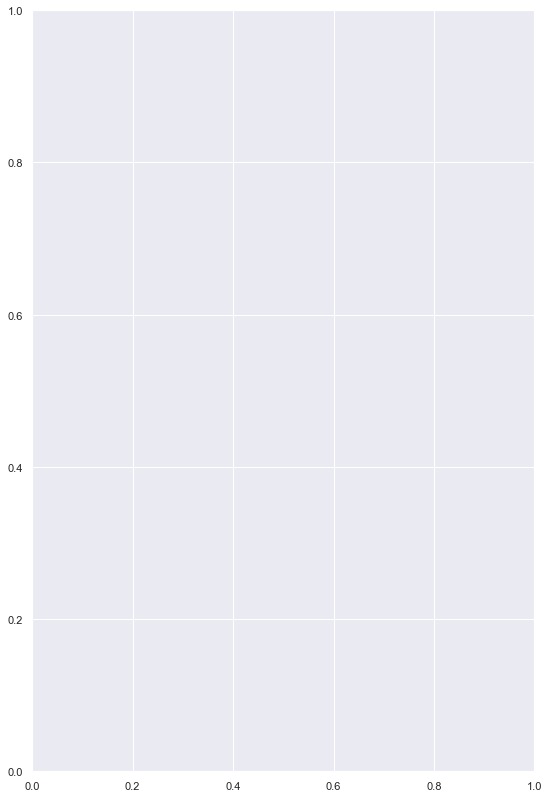

In [96]:
sns.set()
fig, ax1 = plt.subplots(figsize=(9, 14))

pos = np.arange(len(predictor_cols))

rects = ax1.barh(pos, reg.coef_,
                 align='center',
                 height=0.5,
                 tick_label=predictor_cols
                )
plt.show()

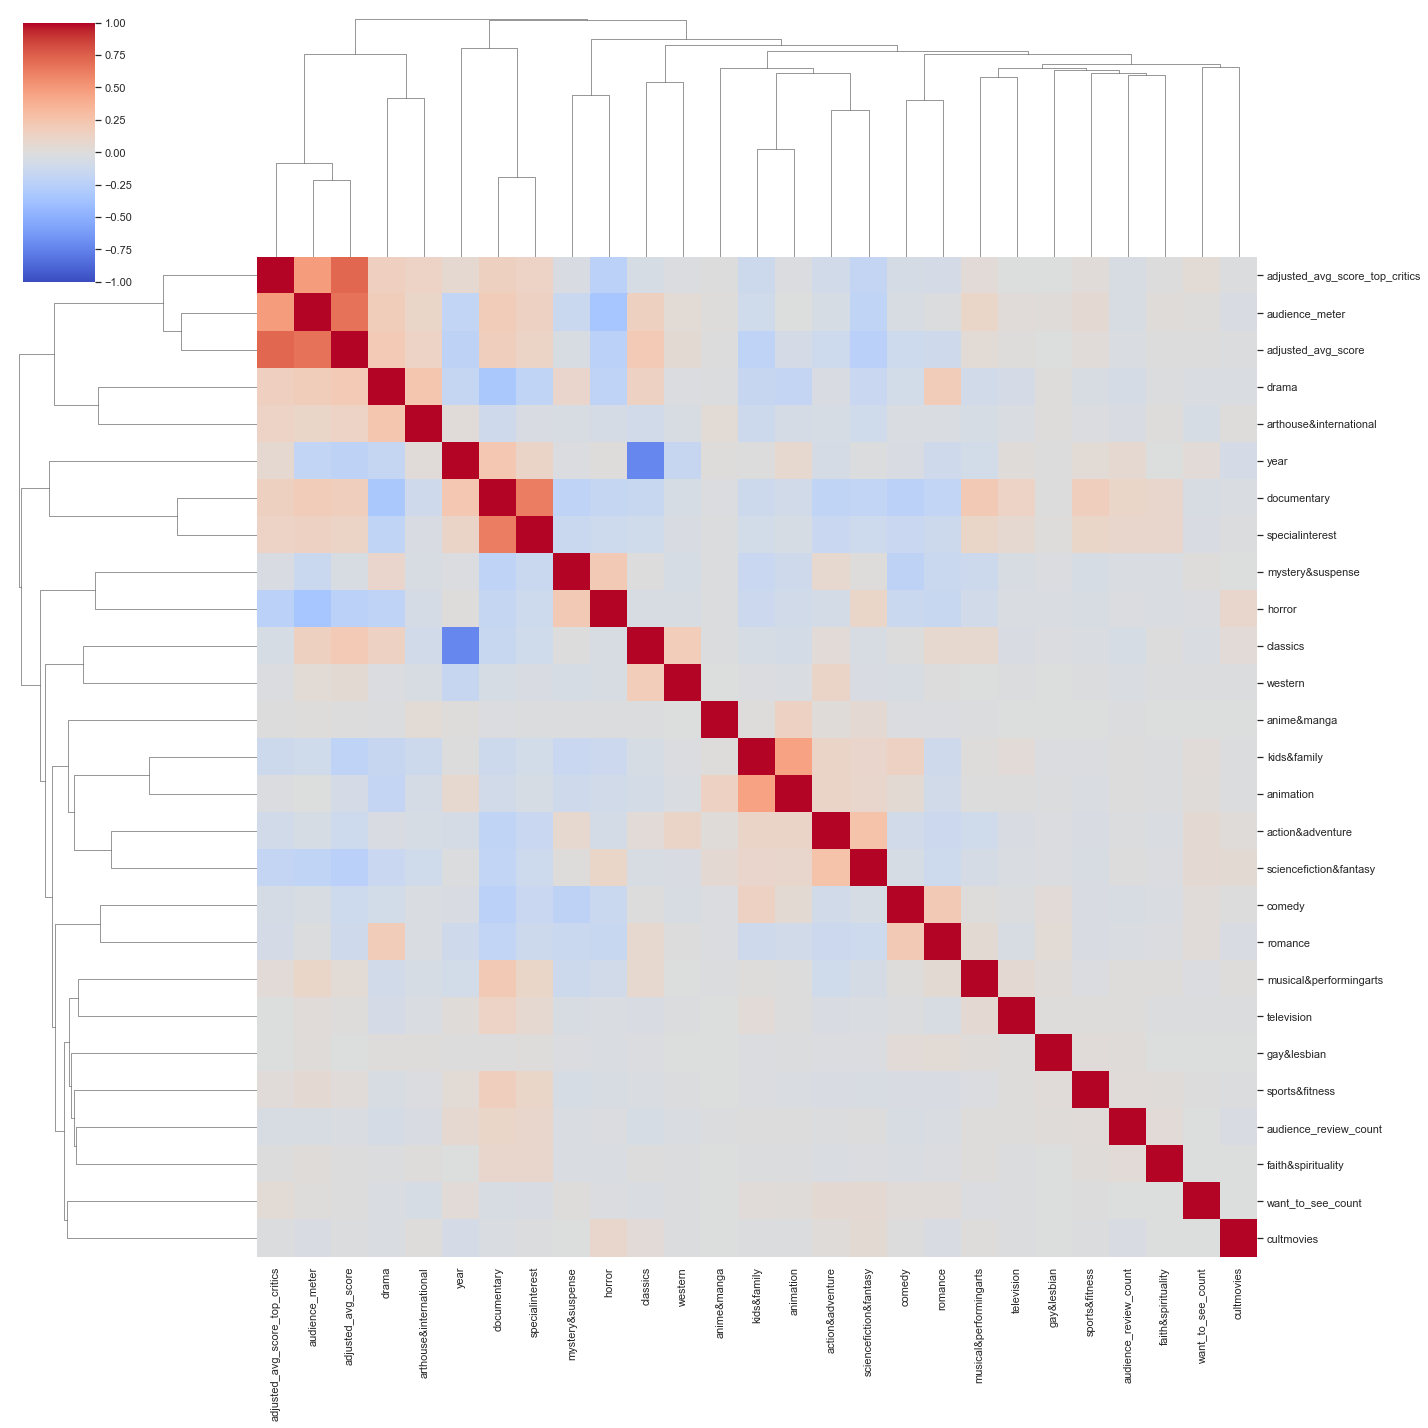

In [55]:
import seaborn as sns
corr = df_with_personal_ratings[predictor_cols].corr()
sns.clustermap(corr.fillna(0), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, 
            vmin=-1, vmax=1, center=0,cmap='coolwarm',figsize=(20, 20))

In [56]:
# get rid of: avg_score_audience tomatometer top_critics_review_count  
top_correlations = corr[corr!=1].unstack().sort_values(kind="quicksort",ascending=False).drop_duplicates()
top_correlations

adjusted_avg_score  adjusted_avg_score_top_critics    0.725779
                    audience_meter                    0.676452
specialinterest     documentary                       0.631737
audience_meter      adjusted_avg_score_top_critics    0.487846
kids&family         animation                         0.456868
                                                        ...   
adjusted_avg_score  sciencefiction&fantasy           -0.239060
drama               documentary                      -0.326082
horror              audience_meter                   -0.348741
classics            year                             -0.726494
year                year                                   NaN
Length: 352, dtype: float64